# Neuron Modeling Project

This notebook contains some messing around to get first contact with the modeling of a neuron and a somewhat biologically realistic neuronal network. As the filename suggests, this is just a kind of playground...

In [288]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt



# Integrate and Fire Neuron Model

An integrate-and-fire neuron is a simplified model that treats a neuron’s membrane like a leaky RC circuit. It continuously integrates incoming current. When the membrane potential reaches a set threshold $V_{th}$, the model emits a spike and resets the potential to a value $V_{reset}$ below threshold. This avoids modeling the ionic mechanisms of action potentials and focuses only on subthreshold voltage dynamics, greatly reducing computational cost. Variants such as the leaky integrate-and-fire model add a passive leak term and can be extended to include phenomena like spike-rate adaptation for more realistic behavior. (Dayan & Abbot, 2001, p.162 ff.)

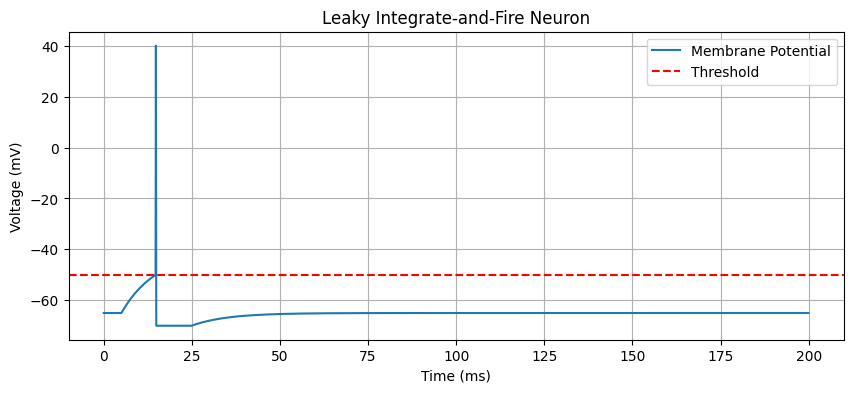

In [289]:

tau_m = 10.0      # Membrane time constant (in ms)
R_m = 1.0         # Membrane resistance (in MΩ)
V_rest = -65.0    # Resting potential (in mV)
V_th = -50.0      # Threshold potential (in mV)
V_reset = -70.0   # Reset potential after spike (in mV)
t_ref = 10.0      # Refractory period (in ms)

dt = 0.1  # Time step (in ms)
T = 200   # Total time (in ms)
time = np.arange(0, T, dt)


I = np.zeros(len(time))
I[50:150] = 24 # stimulus whihc is applied in specified period


V = np.full(len(time), V_rest)
spike_times = []
refractory_counter = 0


for t in range(1, len(time)):
    if refractory_counter > 0:
        V[t] = V_reset
        refractory_counter -= dt
    else:
        dV = (dt / tau_m) * (-(V[t-1] - V_rest) + R_m * I[t-1])
        V[t] = V[t-1] + dV
        
        if V[t] >= V_th:
            V[t] = 40.0  # spike
            spike_times.append(time[t])
            refractory_counter = t_ref


plt.figure(figsize=(10, 4))
plt.plot(time, V, label='Membrane Potential')
plt.axhline(V_th, color='r', linestyle='--', label='Threshold')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Leaky Integrate-and-Fire Neuron')
plt.legend()
plt.grid()
plt.show()


# Hodgkin-Huxley Single Neuron Model
The Hodgkin–Huxley model is a biophysical description of how a neuron generates and propagates action potentials.
It treats a small patch of membrane as an electrical circuit where:
- The lipid membrane is a capacitor ($C_m$).
- Ion channels are voltage-dependent conductances for sodium ($g_{Na}$) and potassium ($g_K$), plus a passive leak ($g_L$).
- Each ionic current follows Ohm’s law ($I=g(V-E)$), with its own reversal potential $E_{ion}$.

The model consists of a differential equation for the membrane voltage coupled to gating-variable equations (m, h, n) that describe how channel conductances open and close with voltage and time. By solving these equations, the model reproduces the shape, threshold, and refractory behavior of real action potentials and underlies most modern conductance-based neuron models.


## The Hodgkin-Huxley Equations:
$ C \frac{dV}{dt} = I_{app} - g_{Na}m^3h(V-E_{Na}) - g_Kn^4(V-E_K) - g_L(V-E_L) $

With...
|Symbol|Formula|
|---|---|
| $I_{Na_V}$ | $g_{Na}m^3h(V-E_{Na})$ |
| $I_{K_V}$ | $g_Kn^4(V-E_K)$ |
| $I_L$ | $g_L(V-E_L)$ |



$ \frac{dm}{dt} = -\frac{m-m_\infty(V)}{\tau_m(V)} $

$ \frac{dh}{dt} = -\frac{h-h_\infty(V)}{\tau_h(V)} $

$ \frac{dn}{dt} = -\frac{n-n_\infty(V)}{\tau_n(V)} $



The description, parameters and equations for the model are taken from:
- "Theoretical Neuroscience", Dayan and Abbot (2005)
- "Cellular Biophysics and Modeling", Smith (2019)
- "Models of the Mind", Lindsay (2022)


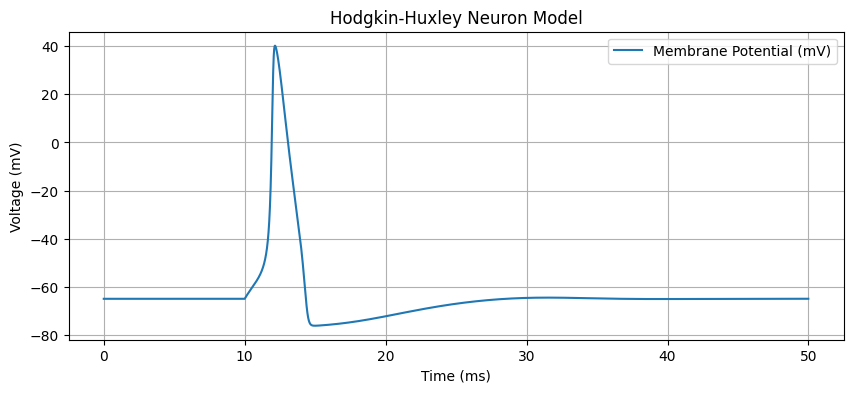

In [290]:
dt = 0.01   # Δ in ms
T = 50.0    # total time in ms
time = np.arange(0, T, dt)

C_m = 1.0      # membrane capacitance, in uF/cm^2
g_Na = 120.0   # Sodium (Na) max conductance, in mS/cm^2
g_K = 36.0     # Potassium (K) max conductance, in mS/cm^2
g_L = 0.3      # Leak max conductance, in mS/cm^2

E_Na = 50.0    # Sodium equilibrium potential, in mV
E_K = -77.0    # Potassium equilibrium potential, in mV
E_L = -54.387  # Leak equilibrium potential, in mV


def alpha_n(V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V):  return 0.125 * np.exp(-(V + 65) / 80)

def alpha_m(V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V):  return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V):  return 1 / (1 + np.exp(-(V + 35) / 10))



I_ext = np.zeros_like(time)
I_ext[1000:1200] = 10  # stimulus


V = np.full_like(time, -65.0)  # membrane potential
m = np.zeros_like(time)
h = np.zeros_like(time)
n = np.zeros_like(time)

# starting steady state
V[0] = -65
m[0] = alpha_m(V[0]) / (alpha_m(V[0]) + beta_m(V[0]))
h[0] = alpha_h(V[0]) / (alpha_h(V[0]) + beta_h(V[0]))
n[0] = alpha_n(V[0]) / (alpha_n(V[0]) + beta_n(V[0]))


for t in range(1, len(time)):
    gNa = g_Na * m[t-1] ** 3 * h[t-1]
    gK  = g_K  * n[t-1] ** 4
    gL  = g_L

    # Currents
    INa = gNa * (V[t-1] - E_Na)
    IK  = gK  * (V[t-1] - E_K)
    IL  = gL  * (V[t-1] - E_L)

    # update
    dV = dt * (I_ext[t-1] - INa - IK - IL) / C_m
    V[t] = V[t-1] + dV

    # update gating
    m[t] = m[t-1] + dt * (alpha_m(V[t-1]) * (1 - m[t-1]) - beta_m(V[t-1]) * m[t-1])
    h[t] = h[t-1] + dt * (alpha_h(V[t-1]) * (1 - h[t-1]) - beta_h(V[t-1]) * h[t-1])
    n[t] = n[t-1] + dt * (alpha_n(V[t-1]) * (1 - n[t-1]) - beta_n(V[t-1]) * n[t-1])



plt.figure(figsize=(10, 4))
plt.plot(time, V, label='Membrane Potential (mV)')
plt.title('Hodgkin-Huxley Neuron Model')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.grid(True)
plt.legend()
plt.show()





---

# Hodgkin-Huxley Neural Network

In [ ]:
class HodgkinHuxleyNeuron:
    def __init__(self, dt = 0.01, C_m = 1.0, neuron_id = 0, refractory_period = 2.0):
        """Create a Neuron based on the Hodgkin-Huxley Model.
        
        Parameters:
        `dt`:                timestep in ms (default: 0.01)
        `C_m`:               membrane capacitance, in uF/cm^2 (default: 1.0)
        `neuron_id`:         What id does the neuron have in the network (default: 0)
        `refractory_period`: Refractory period in ms (default: 2.0)
        """
        self.id = neuron_id
        self.dt = dt
        self.C_m = C_m
        self.g_Na = 120.0
        self.g_K = 36.0
        self.g_L = 0.3
        self.E_Na = 50.0
        self.E_K = -77.0
        self.E_L = -54.387
        self.V = -65.0
        self.m = self.alpha_m(self.V) / (self.alpha_m(self.V) + self.beta_m(self.V))
        self.h = self.alpha_h(self.V) / (self.alpha_h(self.V) + self.beta_h(self.V))
        self.n = self.alpha_n(self.V) / (self.alpha_n(self.V) + self.beta_n(self.V))
        self.V_history = [self.V]
        self.spike_times = []
        self.last_V = self.V
        self.spike_threshold = 0.0
        self.t = 0.0
        
        # track refractory period
        self.refractory_period = refractory_period
        self.last_spike_time = -1000.0


    def alpha_n(self, V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    def beta_n(self, V):  return 0.125 * np.exp(-(V + 65) / 80)
    def alpha_m(self, V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    def beta_m(self, V):  return 4 * np.exp(-(V + 65) / 18)
    def alpha_h(self, V): return 0.07 * np.exp(-(V + 65) / 20)
    def beta_h(self, V):  return 1  /  (1  +  np.exp(-(V + 35) / 10))


    def update(self, I_ext = 0.0):
        time_since_last_spike = self.t - self.last_spike_time
        in_refractory = time_since_last_spike < self.refractory_period
        
        if not in_refractory:
            gNa = self.g_Na * self.m ** 3 * self.h
            gK  = self.g_K * self.n ** 4
            gL  = self.g_L
            INa = gNa * (self.V - self.E_Na)
            IK  = gK  * (self.V - self.E_K)
            IL  = gL  * (self.V - self.E_L)
            dV = self.dt * (I_ext - INa - IK - IL) / self.C_m
            self.last_V = self.V
            self.V += dV
            self.m += self.dt * (self.alpha_m(self.V) * (1 - self.m) - self.beta_m(self.V) * self.m)
            self.h += self.dt * (self.alpha_h(self.V) * (1 - self.h) - self.beta_h(self.V) * self.h)
            self.n += self.dt * (self.alpha_n(self.V) * (1 - self.n) - self.beta_n(self.V) * self.n)

            spiked = self.last_V < self.spike_threshold and self.V >= self.spike_threshold
            
            if spiked:
                self.spike_times.append(self.t)
                self.last_spike_time = self.t
                # Reset after spike
                self.V = -65.0
                self.m = 0.0
                self.h = 0.0
                self.n = 1.0
                
        else: # clamp voltgae during refractory period
            self.last_V = self.V
            self.V = -65.0

        self.t += self.dt
        self.V_history.append(self.V)


    def get_voltage_history(self): return np.array(self.V_history)
    
    def has_spiked(self): return self.last_V < self.spike_threshold and self.V >= self.spike_threshold

    def just_spiked(self): return self.last_V < self.spike_threshold and self.V >= self.spike_threshold

    def is_refractory(self): return (self.t - self.last_spike_time) < self.refractory_period

    def reset(self): self.__init__(self.dt, self.C_m, self.id, self.refractory_period)


In [ ]:
class NeuronalNetwork:
    def __init__(self, num_neurons, dt = 0.01, T = 50.0, refractory_periods = None):
        """Create a neural network based on the Hodgkin-Huxley Model.
        
        Parameters:
        `num_neurons`:        total number of individual neurons in the network
        `dt`:                 timestep in ms (default: 0.01)
        `T`:                  total time in ms (default: 50.0)
        `refractory_periods`: List of refractory periods for each neuron (default: 2.0ms for all)
        """
        
        self.dt = dt
        self.T = T
        self.steps = int(T / dt)
        self.time = np.arange(0, T + dt, dt)

        if refractory_periods is None:
            refractory_periods = [10.0] * num_neurons
        elif len(refractory_periods) != num_neurons:
            raise ValueError(f"refractory_periods length ({len(refractory_periods)}) must match num_neurons ({num_neurons})")

        self.neurons = [HodgkinHuxleyNeuron(dt=dt, neuron_id=i, refractory_period=refractory_periods[i]) for i in range(num_neurons)]

        # Connectivity: weight[i, j] means (j -> i)
        self.weights: list[tuple[float, float]] = np.zeros((num_neurons, num_neurons))
        self.syn_delay = int(1.0 / dt)
        self.syn_duration = int(3.0 / dt)

        self.syn_queue = [np.zeros(self.steps + 100) for _ in self.neurons]
        self.I_ext = np.zeros((num_neurons, self.steps))


    def connect(self, source, target, weight):
        self.weights[target, source] = weight


    def set_current_for_neuron(self, neuron_idx, t_start, t_end, amplitude):
        self.I_ext[neuron_idx, int(t_start / self.dt):int(t_end / self.dt)] = amplitude


    def simulate(self):
        for t in range(self.steps):
            for i, neuron in enumerate(self.neurons):
                I = self.I_ext[i, t] + self.syn_queue[i][t]
                
                spikes_before = len(neuron.spike_times)
                neuron.update(I_ext=I)

                spikes_after = len(neuron.spike_times)

                if spikes_after > spikes_before:
                    for j, _ in enumerate(self.neurons):
                        weight = self.weights[j, i]

                        if weight != 0:
                            for k in range(self.syn_delay, self.syn_delay + self.syn_duration):
                                if t + k < len(self.syn_queue[j]):
                                    self.syn_queue[j][t + k] += weight


    def draw_architecture(self, layer_assignment=None):
        G = nx.DiGraph()
        [G.add_node(i) for i, _ in enumerate(self.neurons)]

        # add all connections from weight matrix
        for i in range(len(self.neurons)):
            for j in range(len(self.neurons)):
                if self.weights[i, j] != 0:
                    G.add_edge(j, i, weight=self.weights[i, j])  # FIXED: j,i not i,j

        # make layout look like typical neuroal network architecture
        if layer_assignment:
            pos = {}
            max_nodes = max(len(nodes) for nodes in layer_assignment.values())

            for layer, nodes in layer_assignment.items():
                n = len(nodes)
                y_coords = [((n - 1) / 2) - i for i in range(n)]  # center nodes
                for node, y in zip(nodes, y_coords):
                    pos[node] = (layer, y)
        else:
            pos = nx.spring_layout(G)

        plt.figure(figsize=(8, 5))
        
        nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, arrows=True, arrowstyle='->', arrowsize=20)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f'{w:.0f}' for (i, j), w in edge_labels.items()})

        plt.title("Hodgkin-Huxley Neural Network Architecture")
        plt.axis('off')
        plt.show()


    def plot_results(self):
        plt.figure(figsize=(10, 6))

        for i, neuron in enumerate(self.neurons):
            plt.plot(self.time, neuron.get_voltage_history(), label=f'Neuron {i}')
            
        plt.xlabel("Time (ms)")
        plt.ylabel("Membrane Potential (mV)")
        plt.title("Hodgkin-Huxley Network Dynamics")
        plt.legend()
        plt.grid(True)
        plt.show()




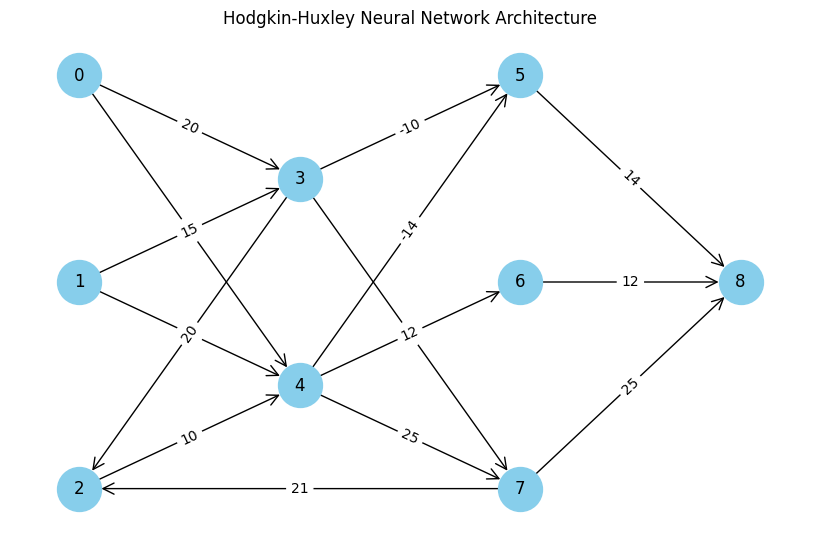

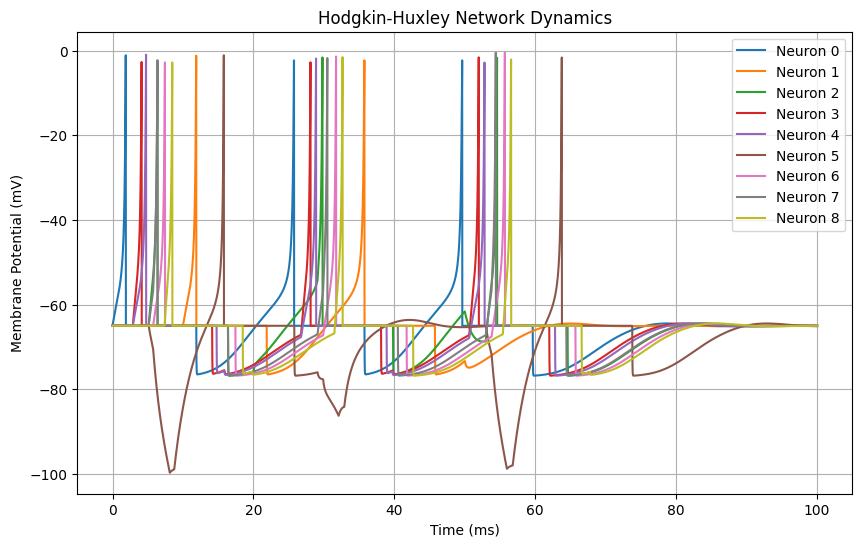

In [299]:
net = NeuronalNetwork(num_neurons=9, dt=0.01, T=100.0)

# Layer 0 (input) -> Layer 1
net.connect(0, 3, 20.0)
net.connect(0, 4, 10.0)
net.connect(1, 3, 15.0)
net.connect(1, 4, 20.0)
net.connect(2, 4, 10.0)

# Layer 1 -> Layer 2 + Feedback to Layer 0
net.connect(3, 2, 20.0)
net.connect(3, 5, -10.0)
net.connect(3, 7, 14.0)
net.connect(4, 5, -14.0)
net.connect(4, 6, 12.0)
net.connect(4, 7, 25.0)

# Layer 2 -> Layer 3 + Feedback
net.connect(5, 8, 14.0)
net.connect(6, 8, 12.0)
net.connect(7, 8, 25.0)
net.connect(7, 2, 21.0)

# Input layer -> inital input
net.set_current_for_neuron(neuron_idx=0, t_start=0.0, t_end=50.0, amplitude=10.0)
net.set_current_for_neuron(neuron_idx=1, t_start=10.0, t_end=50.0, amplitude=10.0)
net.set_current_for_neuron(neuron_idx=2, t_start=20.0, t_end=50.0, amplitude=10.0)


# TODO:
# - create oscillations
# - look for some real biological data and compare it with model results
# - add learning -> hebbian learning rule?!
# - more realistic neuron -> multi-compartment model


# format: "layer: [list of neurons in that layer]"
layer_assignment = {
    0: [0, 1, 2],   # Input layer
    1: [3, 4],      # Hidden
    2: [5, 6, 7],   # Hidden
    3: [8]          # Output
}


net.draw_architecture(layer_assignment)
net.simulate()
net.plot_results()



## Test the efefct of the refractory period on spikes

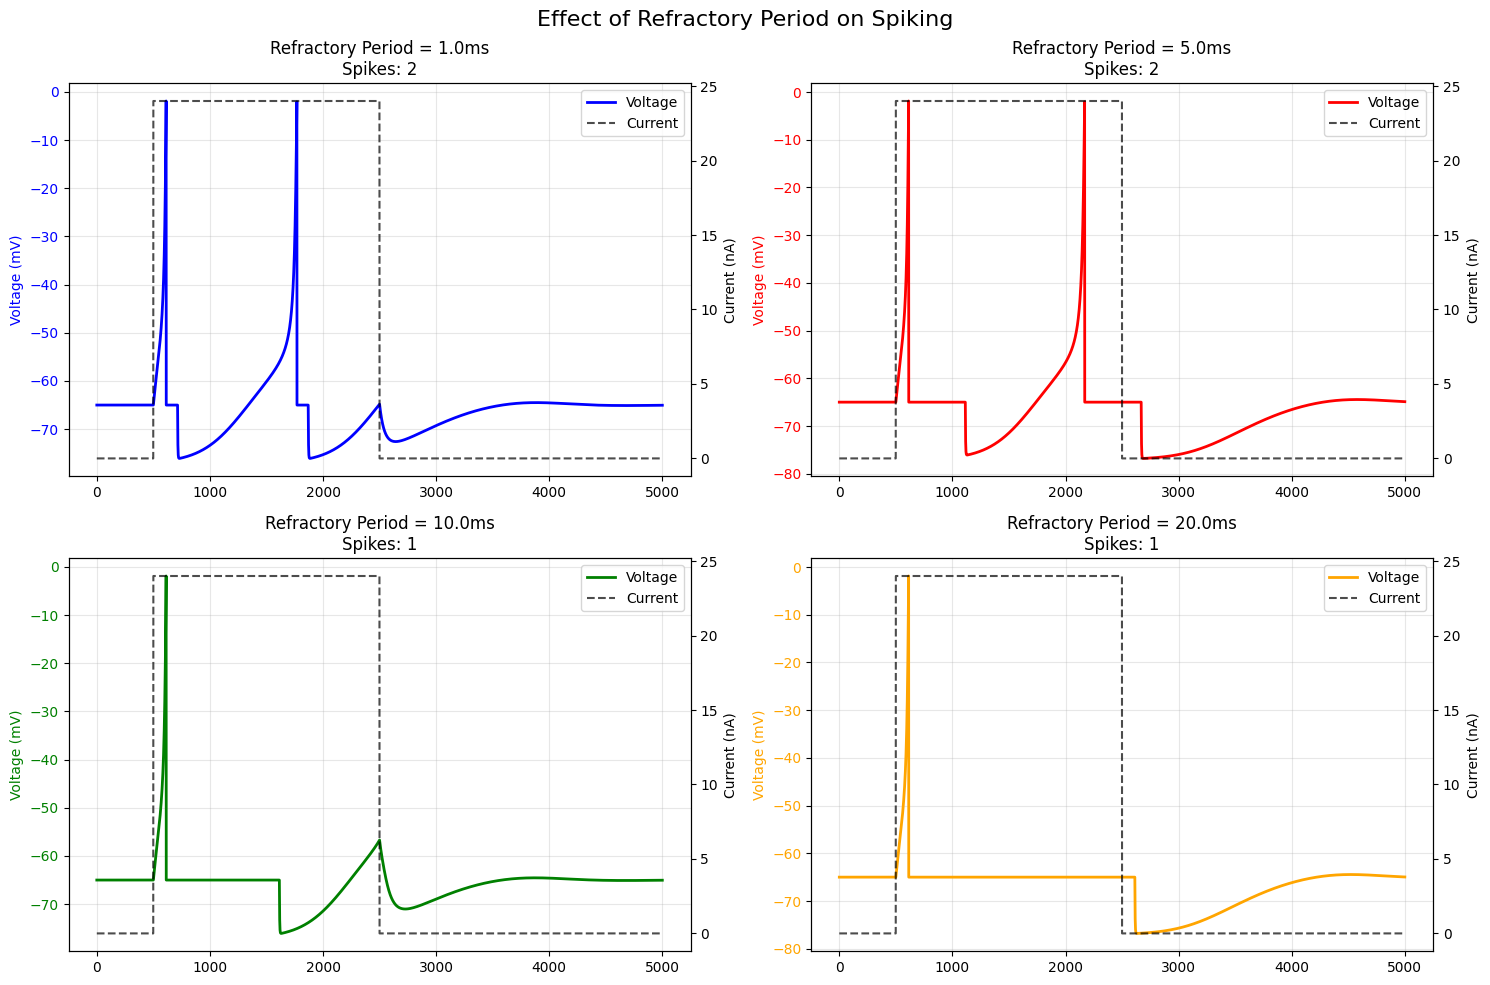

In [ ]:
refractory_periods = [1.0, 5.0, 10.0, 20.0]
colors = ['blue', 'red', 'green', 'orange']

plt.figure(figsize=(15, 10))

for i, ref_period in enumerate(refractory_periods):
    neuron = HodgkinHuxleyNeuron(dt=0.01, refractory_period=ref_period)
        
    I_test = np.zeros(5000) # 5000 steps = 50ms
    I_test[500:2500] = 24.0 # Apply current for 20ms
    
    # Simulate
    for j in range(len(I_test)):
        neuron.update(I_ext=I_test[j])
    
    plt.subplot(2, 2, i+1)
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # voltages / spikes
    line1 = ax1.plot(neuron.get_voltage_history(), color=colors[i], linewidth=2, label='Voltage')
    ax1.set_ylabel('Voltage (mV)', color=colors[i])
    ax1.tick_params(axis='y', labelcolor=colors[i])
    ax1.grid(True, alpha=0.3)
    
    # applied current
    line2 = ax2.plot(I_test, color='black', linewidth=1.5, linestyle='--', alpha=0.7, label='Current')
    ax2.set_ylabel('Current (nA)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    
    # combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    plt.title(f'Refractory Period = {ref_period}ms\nSpikes: {len(neuron.spike_times)}')
    plt.xlabel('Time (steps: 100 steps = 1ms)')
    
plt.suptitle('Effect of Refractory Period on Spiking', fontsize=16)
plt.tight_layout()
plt.show()
